# Fluxonium-transmon gates
We study different schemes for two-qubit gates between fluxonium and transmon. 

In [204]:
import numpy as np
import sys
import qutip as qtp 
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import Image, display, Latex
import time

The gates will be based on the following driven Hamiltonian of capacitively coupled fluxonium and transmon

$$H = H_F + H_T + V + H_{drive}$$,

where we have the fluxonium Hamiltonian

$$H_L= 4 E_{C,F} \hat{n}^2_F + \frac{1}{2}E_{L} \hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \varphi_{ext,F}\right), \quad [\hat{\varphi}_F, \hat{n}_F] = i$$,

the transmon Hamiltonian (treated immediately as a Duffing oscillator)

$$H_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b}$$,

where in terms of the transmon's charging energy $E_{C,T}$ and Josephson energy $E_{J, T}$ the transmon's angular velocity $\omega_T$ and anharmonicity $\delta_T$ are

$$ \omega_T = \frac{\sqrt{8 E_{C, T} E_{J, T}}}{\hbar}, \quad \delta_T = - \frac{E_{C,T}}{\hbar} $$.
In addition, the transmon's charge operator can be written as
$$ \hat{n}_T = \frac{i}{2} \biggl( \frac{E_{J, T}}{2 E_{C, T}} \biggr)^{1/4} \bigl( \hat{b}^{\dagger} - \hat{b} \bigr) = \frac{i}{2} \sqrt{\frac{\omega_T}{4 \lvert \delta_T \rvert} }\bigl( \hat{b}^{\dagger} - \hat{b} \bigr).$$

The coupling Hamiltonian is

$$V = J_C  \hat{n}_F \hat{n}_T$$,

and the drive Hamiltonian

$$H_{drive} = 2  f\left( t \right)  \cos \left( \omega_d t + \gamma_d\right) \left( \eta_F  \hat{n}_F + \eta_T \hat{n}_T \right)   \text{  with  } f\left( t \right) = f_0 \dfrac{f\left( t \right)}{f_0}. $$

# 1. Gate a la Ficheux 2020 and how it could work: flux tuning seems needed

Let us introduce the two qubits. We consider a transmon with fundamental frequency $\omega_T/2 \pi = 5.0 \, \mathrm{GHz}$ and anharmonicity $\delta_T/2 \pi = - 300 \, \mathrm{MHz}$.

In [336]:
# Fluxonium parameters (like Qubit A in Ficheux 2020): values in GHz (divided by h)
ec_f = 0.973 
el_f = 0.457 
ej_f = 5.899
# ec_f = 1.027 
# el_f = 0.684 
# ej_f = 5.768
flux_f = 1/2
n_fock_f = 100
# Transmon parameters: values in GHz divided by 2 \pi 
omega_t = 6.8 #6.0 
delta_t = -0.3
n_fock_t = 3

Let us introduce the two qubit objects

In [312]:
levels_f = 7
levels_t = n_fock_t
flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=n_fock_f)
trans = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=n_fock_t)
flx.diagonalize_basis(levels_f)
# The Simple Transmon is already diagonal

In [313]:
energies_f, eig_states_f = flx.eig_states(levels_f)
energies_t, eig_states_t = trans.eig_states(levels_t)
print('Fluxonium')
for k in range(0, 3):
    display(Latex(r'$\omega^{{f}}_{{{} \rightarrow {}}}/2 \pi$ = {:.3f} GHz'.format(k, k + 1, energies_f[k + 1] - energies_f[k] )))
print('------')
print('Transmon')
display(Latex(r'$\omega^{{t}}_{{{} \rightarrow {}}}/2 \pi$ = {:.3f} GHz'.format(0, 1, energies_t[1] - energies_t[0] )))
display(Latex(r'$\omega^{{t}}_{{{} \rightarrow {}}}/2 \pi$ = {:.3f} GHz'.format(1, 2, energies_t[2] - energies_t[1] )))


Fluxonium


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

------
Transmon


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

I notice a small discrepancy of the fluxonium frequency compared to Ficheux 2020. This was not happening in the Nesterov 2020 paper. 

In [314]:
# Matrix elements
print('Fluxonium')
for k in range(0, 2):
    display(Latex(r'$\lvert n^{{f}}_{{{} \rightarrow {}}}\rvert$ = {:.3f}'.format(k, k + 1, 
            np.abs(get_mat_elem(flx.charge_op(), eig_states_f[k], eig_states_f[k + 1])) )))
print('\n')
print('Transmon')
for k in range(0, 2):
    display(Latex(r'$\lvert n^{{t}}_{{{} \rightarrow {}}} \rvert$ = {:.3f}'.format(k, k + 1, 
            np.abs(get_mat_elem(trans.charge_op(), eig_states_t[k], eig_states_t[k + 1])) )))
display(Latex(r'$\sqrt{{2}} \lvert  n^{{t}}_{{{} \rightarrow {}}} \rvert$ = {:.3f}'.format(0, 1, 
            np.sqrt(2)*np.abs(get_mat_elem(trans.charge_op(), eig_states_t[0], eig_states_t[1])) )))


Fluxonium


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



Transmon


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Notice the $\sqrt{2}$ factor for the matrix elements of the transmon. The $n_{1 \rightarrow 2}^f$ matrix element of the fluxonium is approximately half the $n_{0 \rightarrow 1}^t$ of the transmon. Thus, I expect a possible CPHASE-like gate to take twice the time as between two similar transmons. However, this is of course dependent on the transmon parameters.
We can also visualize the matrix elements as

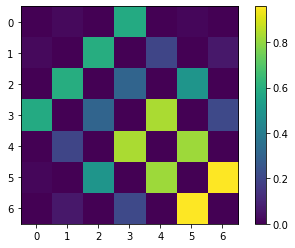

In [315]:
mat_elems_f = flx.mat_elements(operator='charge_op', levels=levels_f)
plt.imshow(np.abs(mat_elems_f))
plt.colorbar()
plt.show()

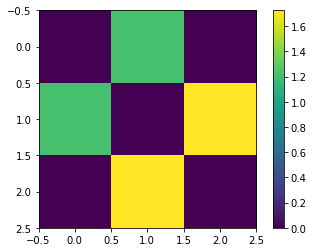

In [316]:
mat_elems_t = trans.mat_elements(operator='charge_op', levels=levels_t)
plt.imshow(np.abs(mat_elems_t))
plt.colorbar()
plt.show()

In the following we plot the energy levels structure. The colors represent the strength of the matrix elements of the charge operators for each transition. 

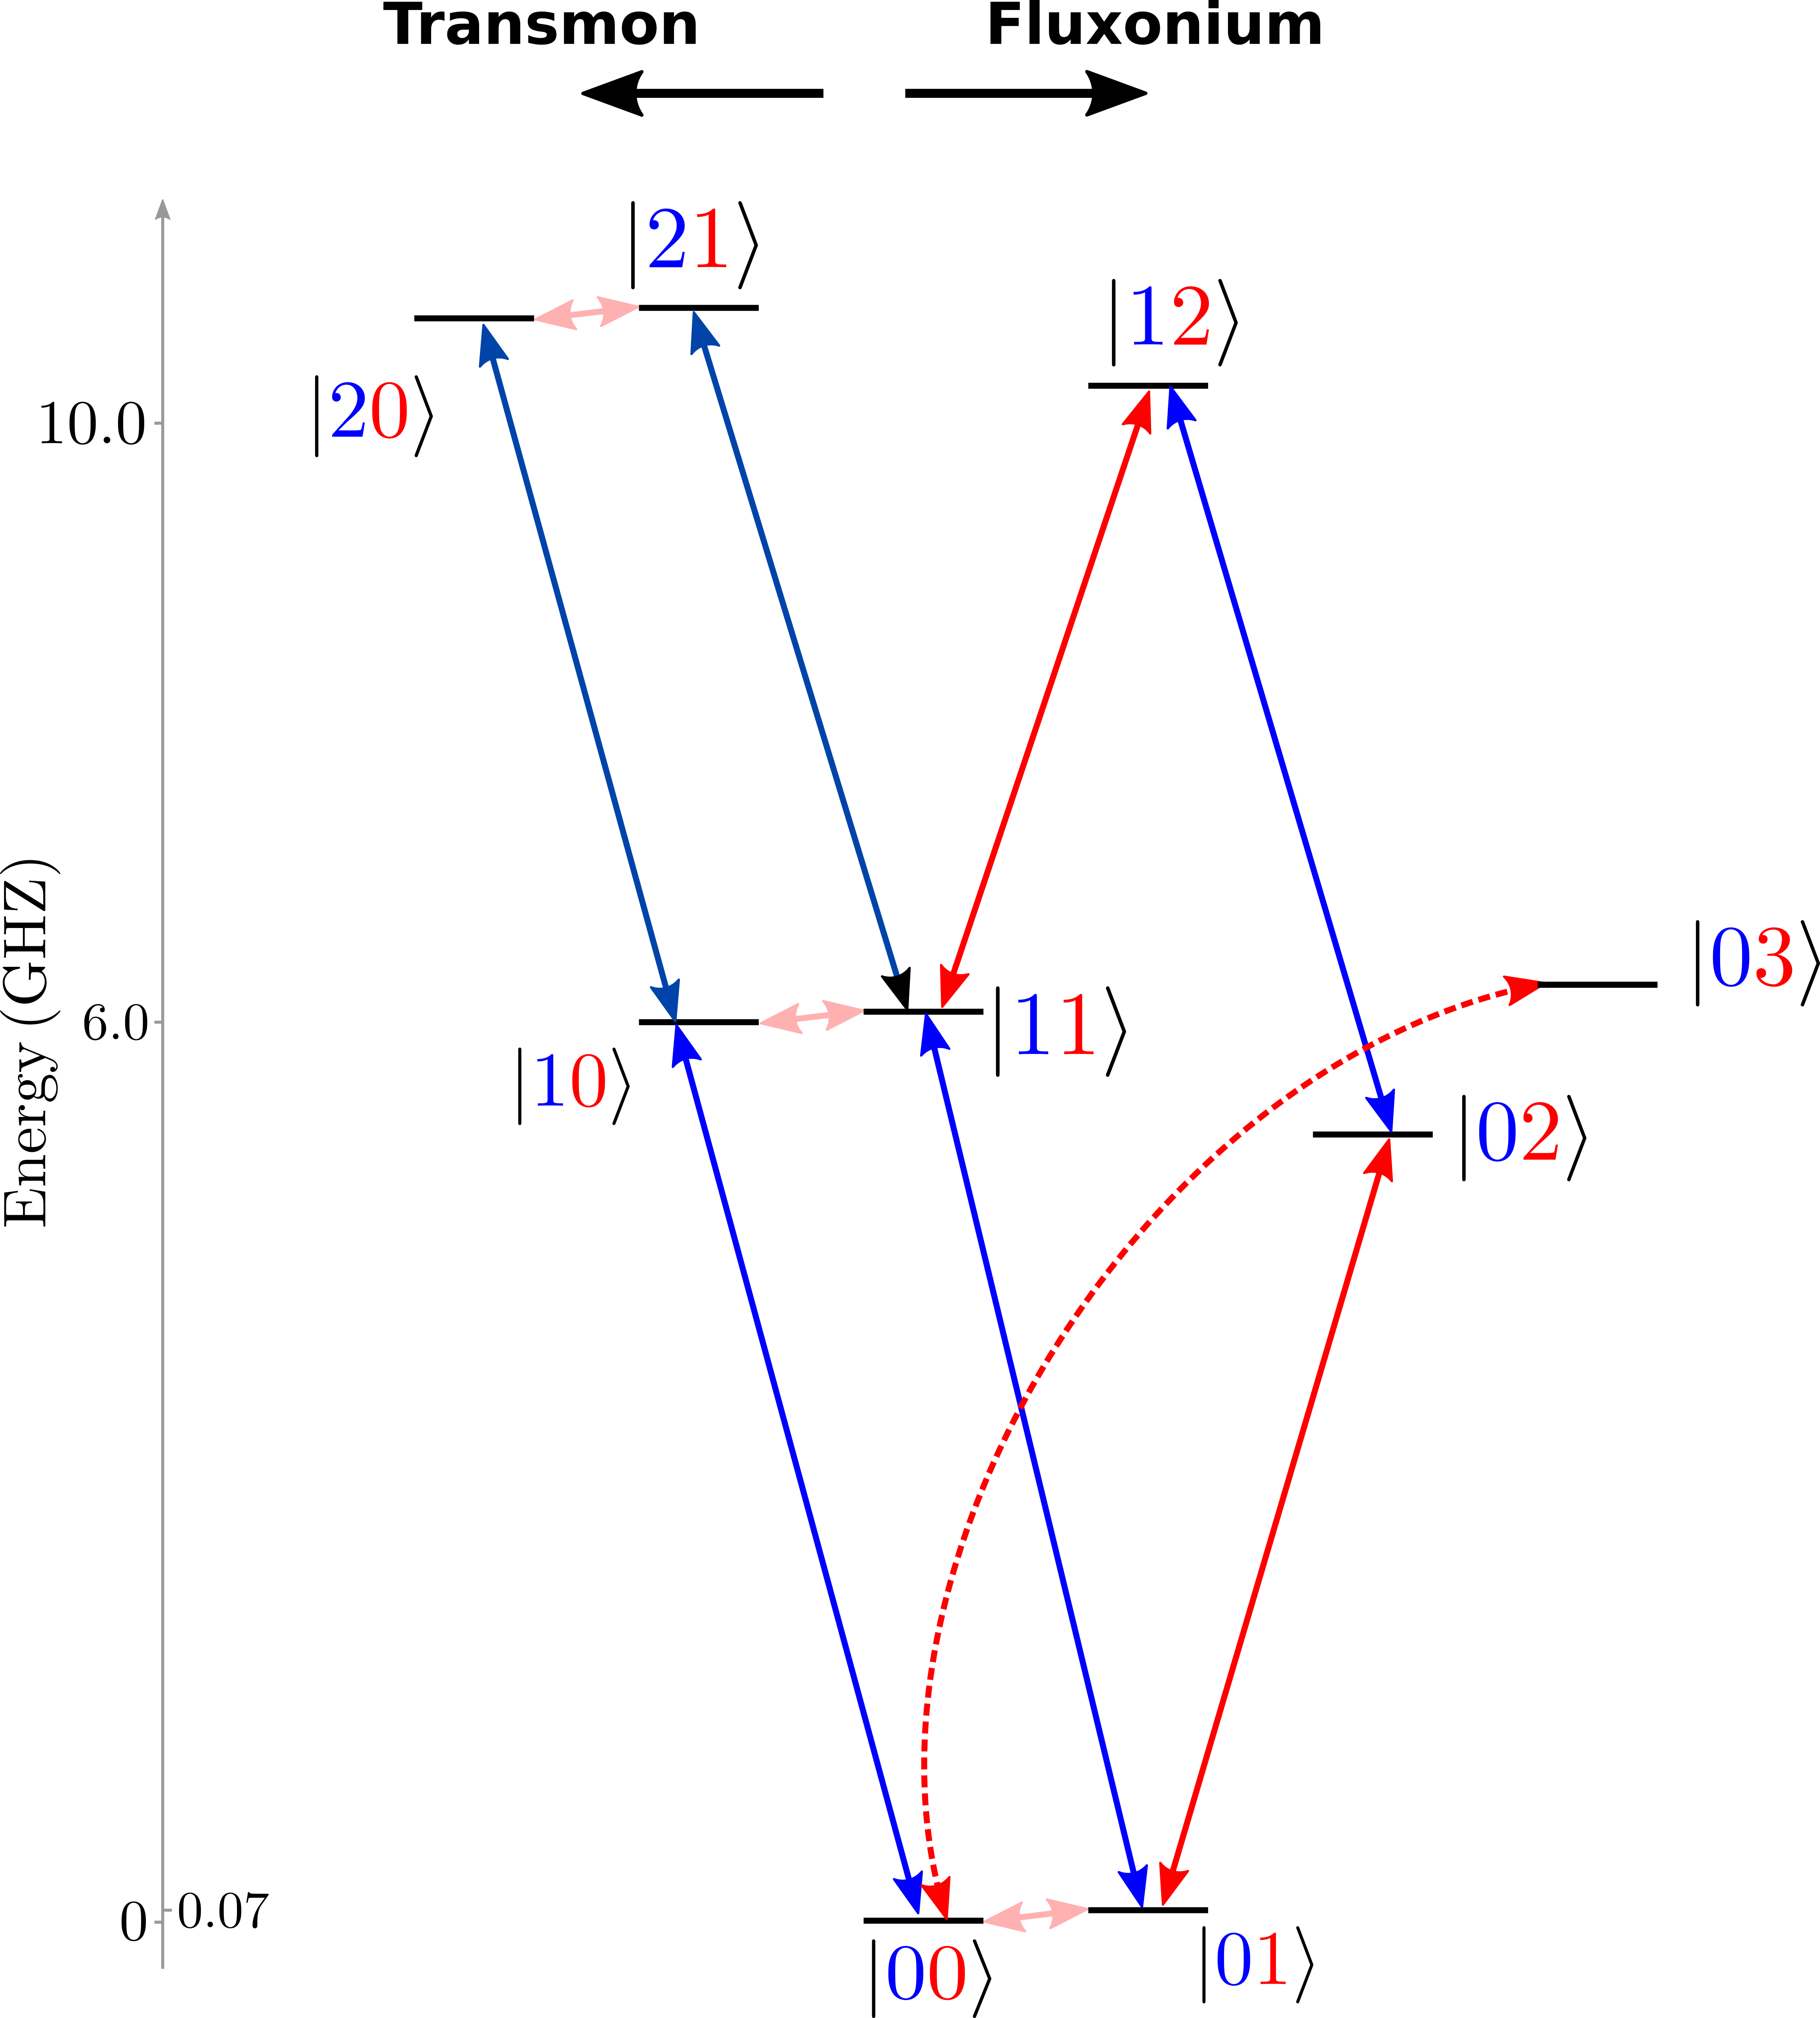

In [317]:
Image("transmon_fluxonium_levels.png", width = 500)

The following represents the strength of the couplings between the levels

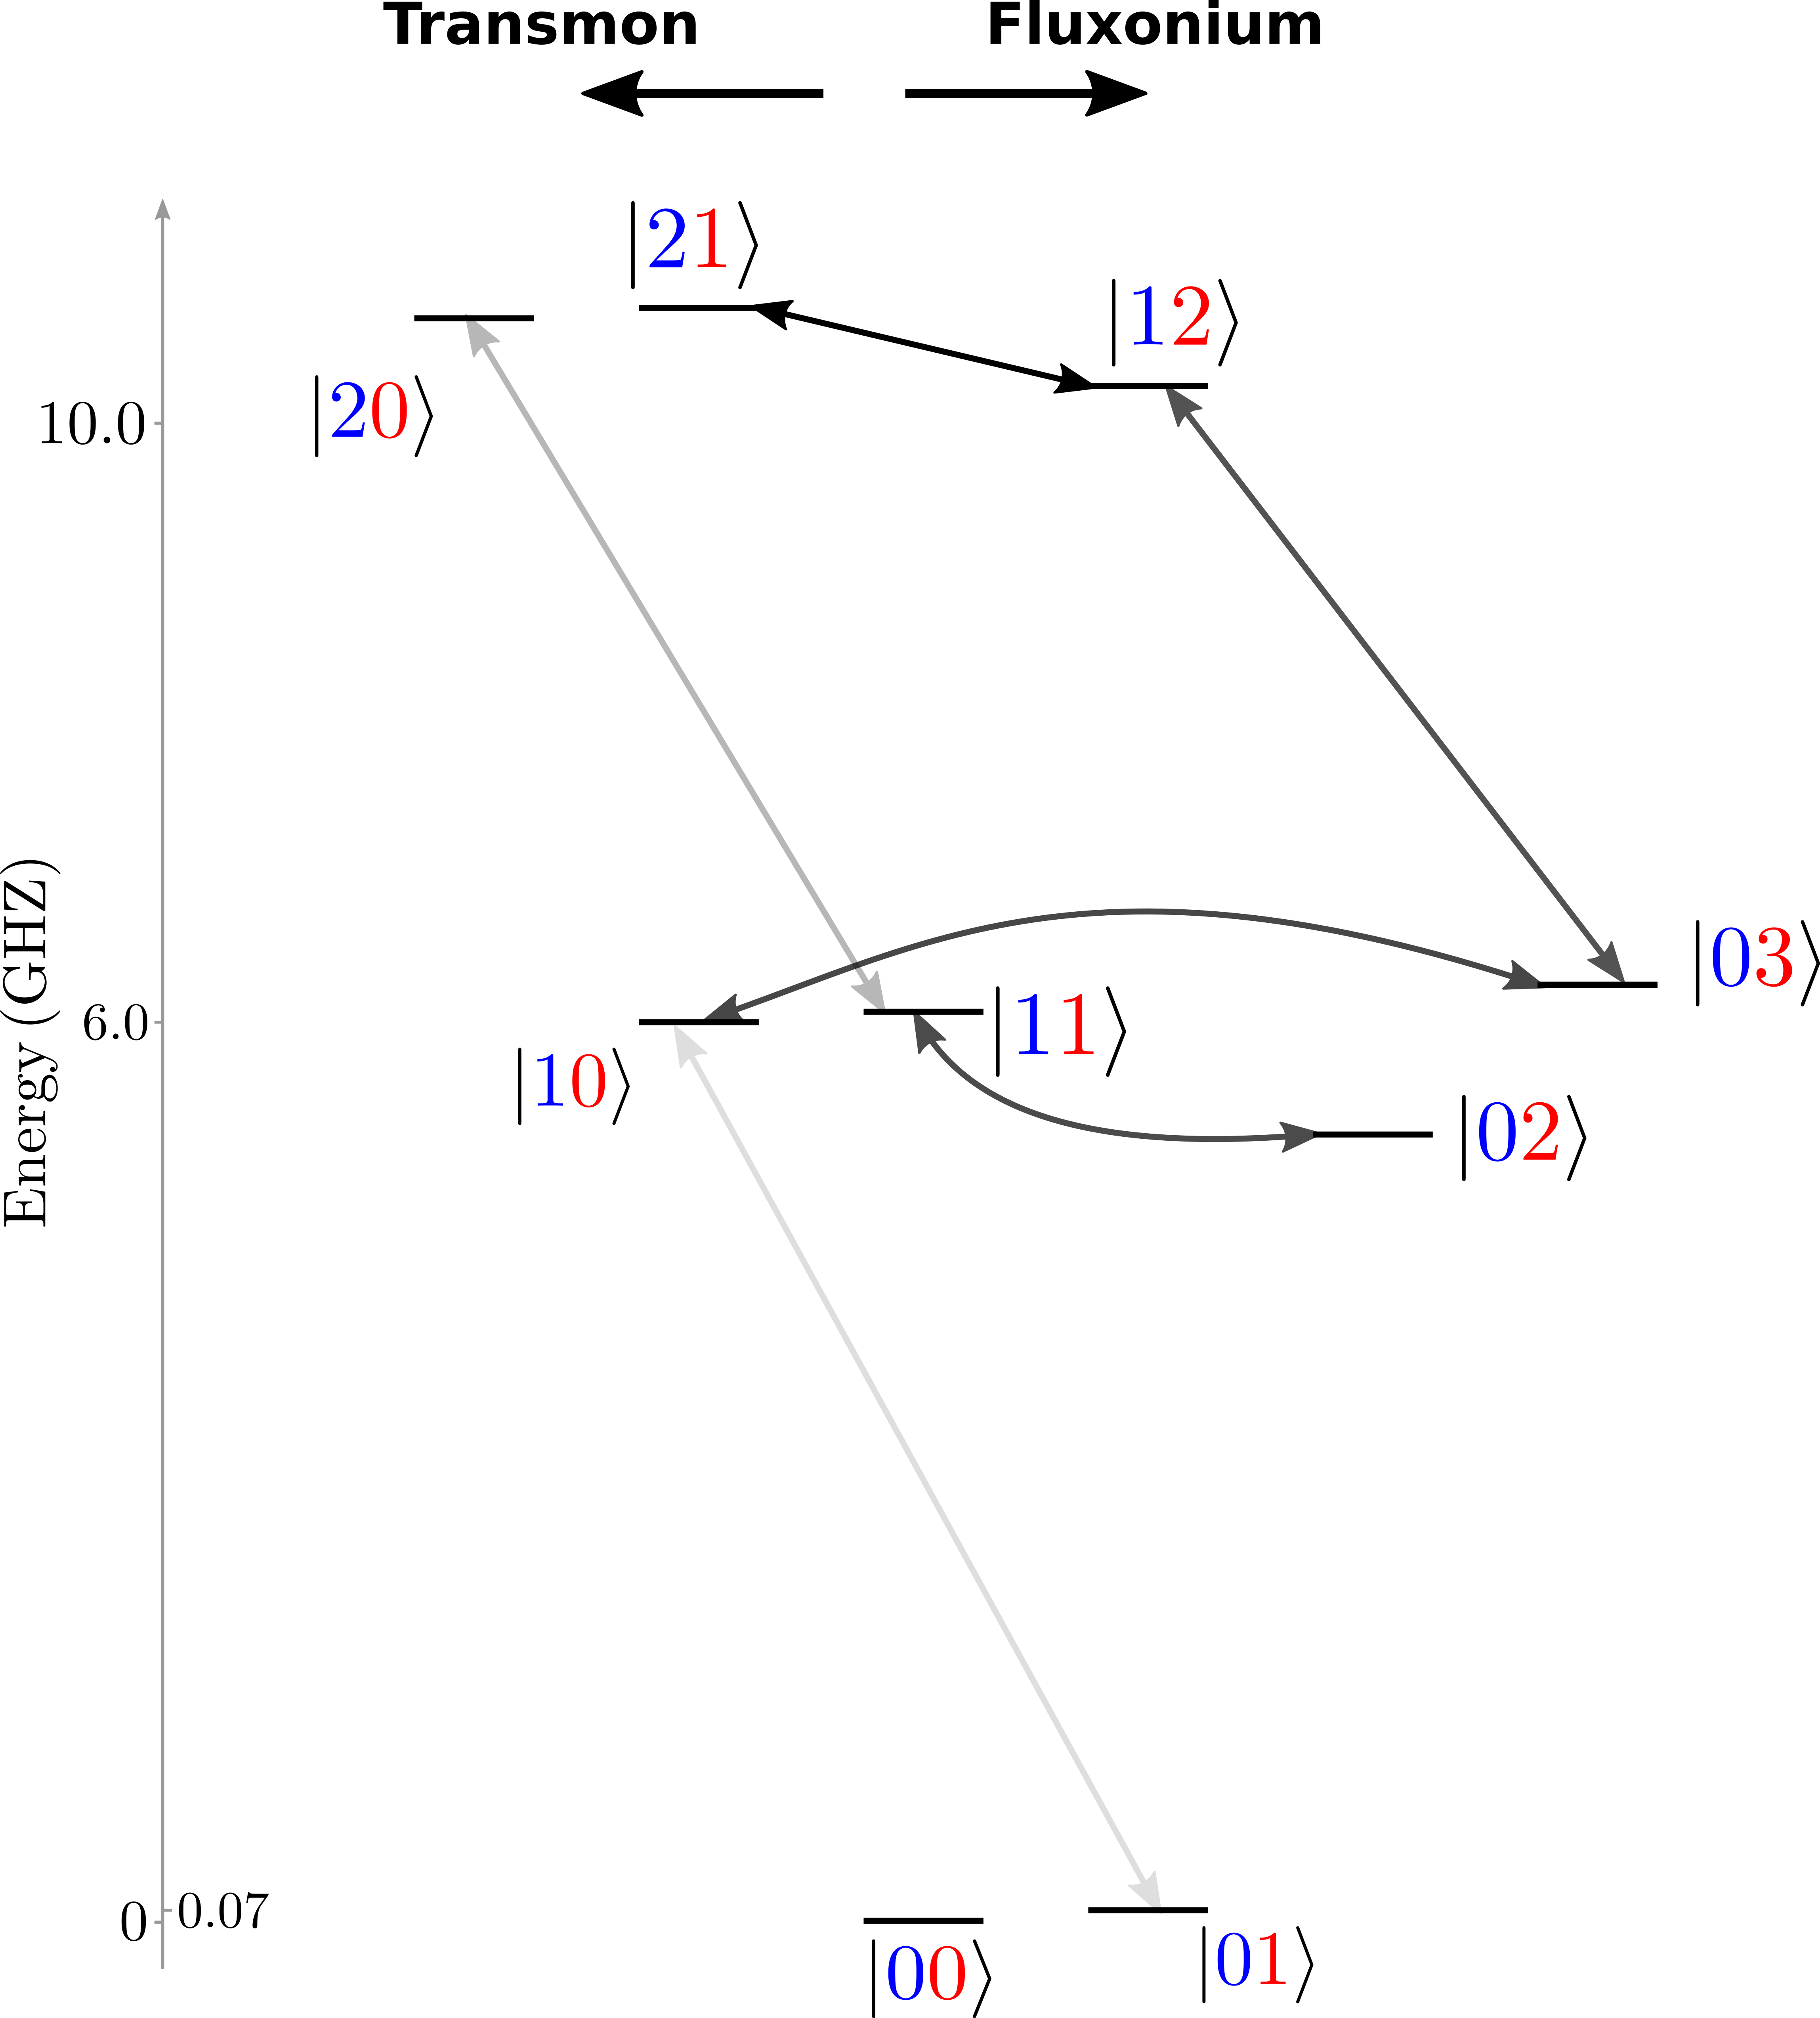

In [423]:
Image("transmon_fluxonium_couplings.png", width = 500)

The previous parameters are not too smart for implementing the Ficheux gate. In fact $\lvert 11 \rangle$ and $\lvert 20 \rangle$ are very close to each other which could result in a high hybridization of the bare levels. This effect could however be exploited in a CPHASE gate. Let us evaluate the hybridization by solving the coupled eigensystem. The energies of the uncoupled system are

In [318]:
bare_energies_tf = np.zeros(levels_f*n_fock_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        bare_energies_tf[count] = energies_t[k] + energies_f[m]
        count += 1
label_converter = np.argsort(bare_energies_tf)

def labels_to_energy(
    lev_t: int, 
    lev_f: int, 
    energies: np.ndarray, 
    label_converter: np.ndarray,
    n_levels_f=levels_f, 
    n_levels_t=n_fock_t, 
) -> float:
    if lev_t >= n_levels_t:
        raise ValueError("Transmon has to be smaller than the total number of transmon levels")
    if lev_f >= n_levels_f:
        raise ValueError("Fluxonium has to be smaller than the total number of fluxonium levels")
    label = lev_t*n_levels_f + lev_f
    index = np.where(label_converter==label)[0][0]
    return energies[index]

def labels_to_state(
    lev_t: int, 
    lev_f: int, 
    eig_states: np.ndarray, 
    label_converter: np.ndarray,
    n_levels_f=levels_f, 
    n_levels_t=n_fock_t, 
) -> float:
    if lev_t >= n_levels_t:
        raise ValueError("Transmon has to be smaller than the total number of transmon levels")
    if lev_f >= n_levels_f:
        raise ValueError("Fluxonium has to be smaller than the total number of fluxonium levels")
    label = lev_t*n_levels_f + lev_f
    index = np.where(label_converter==label)[0][0]
    return eig_states[index]

In [319]:
jc = 0.224*0.1 # GHz 1/10 the in Ficheux 2020 to consider rescaling of parameters
trans_flx = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_tf, eigstates_tf = trans_flx.eig_states()

We conveniently introduce two-dimensional np.ndarray to store the energies so that they can be easily accessed

In [320]:
bare_energy_mat = np.zeros([levels_t, levels_f], dtype=float)
energy_mat = np.zeros([levels_t, levels_f], dtype=float)
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        bare_energy_mat[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, np.sort(bare_energies_tf), 
                                                         label_converter)
        energy_mat[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, energies_tf, label_converter)

We can check that the function labels_to_energy correctly gives the adiabatic continuation of the level. In fact, we expect the energies to be close to the bare ones.

In [321]:
lev_t = 1
lev_f = 1
print("------")
print("E_" + str(lev_t) + str(lev_f) + "^(bare) = " + str(bare_energy_mat[lev_t, lev_f]) + " GHz")
print("------")
print("E_" + str(lev_t) + str(lev_f) + " = " + str(energy_mat[lev_t, lev_f]) + " GHz")

------
E_11^(bare) = 6.288672077096845 GHz
------
E_11 = 6.288771817628877 GHz


We can check that $\lvert 11 \rangle$ and $\lvert 20 \rangle$ show high hybridization. In fact

In [322]:
print("E_{02, bare}/h = " + str(bare_energy_mat[0, 2]) + ' GHz')
print("E_{02}/h = " + str(energy_mat[0, 2]) + ' GHz')
print('------')
print("E_{11, bare}/h = " + str(bare_energy_mat[1, 1]) + ' GHz')
print("E_{11}/h = " + str(energy_mat[1, 1]) + ' GHz')
print('------')

E_{02, bare}/h = 4.6237497456128125 GHz
E_{02}/h = 4.6235664999531 GHz
------
E_{11, bare}/h = 6.288672077096845 GHz
E_{11}/h = 6.288771817628877 GHz
------


To further evaluate the hybridization let us print the amplitudes of the corresponding eigenkets

In [323]:
print("|02>")
print(labels_to_state(0, 2, eigstates_tf, label_converter))
print('------')
print("|11>")
print(labels_to_state(1, 1, eigstates_tf, label_converter))

|02>
[ 2.07161084e-06-0.j  4.19369400e-16+0.j  9.99950710e-01+0.j
  2.34504159e-15+0.j  1.16886327e-05+0.j -1.79600620e-16+0.j
  5.07973409e-06+0.j  1.71115406e-15+0.j -9.81990137e-03+0.j
 -1.32378522e-17+0.j  1.07400385e-03+0.j  1.02945256e-17+0.j
  9.96503610e-04+0.j -5.69188032e-18+0.j  1.89005214e-06+0.j
  5.61842354e-19+0.j -1.93382224e-05+0.j -2.41201595e-18+0.j
 -4.06446943e-06+0.j -5.14467370e-20+0.j -2.98651114e-06+0.j]
------
|11>
[-1.00015137e-04-0.j -1.38777878e-17+0.j -9.81991276e-03+0.j
  8.48692459e-16+0.j  2.01001970e-03+0.j -3.17111763e-17+0.j
  2.09049190e-04+0.j  1.69469570e-14+0.j -9.99947664e-01+0.j
  4.13927876e-16+0.j -1.94806848e-05+0.j  5.46775364e-16+0.j
 -2.21988876e-06+0.j -7.38688633e-16+0.j -1.51045871e-04+0.j
 -3.55401773e-18+0.j -1.97042698e-03+0.j -6.93716522e-18+0.j
 -4.77278271e-04+0.j  1.49333658e-18+0.j -1.09381928e-04+0.j]


Again the hybridization is visible. This suggests to take different parameters for this gate. In this setup the residual $ZZ$ coupling is

In [324]:
def zz(energy_mat):
    return energy_mat[1, 1] + energy_mat[0, 0] - energy_mat[1, 0] - energy_mat[0, 1]

zz_coup = zz(energy_mat)
print('\\xi_ZZ/h = ' +str(zz_coup) + ' GHz')

\xi_ZZ/h = -0.00027924040693561025 GHz


In addition, the $J_C$ parameter seems much larger than its typical value in transmon qubits. This is because it was designed for two fluxonia that have very small matrix elements of the charge operator. Taking the same value and assuming two equal transmons this would result in a $J_1$ coupling

In [325]:
j1_eq_trans = jc*np.abs(get_mat_elem(trans.charge_op(), eig_states_t[0], eig_states_t[1]))**2
print("J1/2 pi assuming two transmons: " + str(j1_eq_trans) + ' GHz')

J1/2 pi assuming two transmons: 0.033366666666666676 GHz


This is an order of magnitude larger than the $J_1$ in the DiCarlo lab that is usually $10-15 \, \mathrm{MHz}$. 
Assuming two fluxonia the $J_1$ coupling would instead be

In [326]:
j1_eq_flx = jc*np.abs(get_mat_elem(flx.charge_op(), eig_states_f[0], eig_states_f[1]))**2
print("J1 assuming two fluxonia: " + str(j1_eq_flx) + ' GHz')

J1 assuming two fluxonia: 1.4344339202469402e-05 GHz


Thus way smaller. 
The Ficheux gate is based on the fact that the frequency of the $\lvert 10 \rangle - \lvert 20 \rvert$ transition is different than the frequency of the $\lvert 11 \rangle - \lvert 21 \rvert$ transition. In particular, this frequency difference
$$
\Delta = \frac{\lvert (E_{20} - E_{10}) - (E_{21} - E_{11}) \rvert}{h},
$$
sets the gate time simply as $t_{\mathrm{gate}} = 1/\Delta $

In [327]:
def delta_ficheux(energy_mat):
    return (energy_mat[0, 2] - energy_mat[0, 1]) - (energy_mat[1, 2] - energy_mat[1, 1])
delta_f = delta_ficheux(energy_mat)
print("Delta = " + str(delta_f) + " GHz")

Delta = 0.007551624496370479 GHz


In the following we will proceed in the following way. We keep $J_C$ fixed and we vary the transmon frequency to look for a candidate frequencies where the ration between the parameter $\Delta$ in Ficheux and the ZZ coupling is large.

## Varying the frequency of the transmon

In [328]:
n_points = 1000
omega_vec = np.linspace(3.5, 7.5, n_points)
zz_coup_vec = np.zeros(n_points, dtype=float)
delta_f_vec = np.zeros(n_points, dtype=float)

In [329]:
start = time.time()

for i in range(0, n_points):
    trans_i = pysqkit.qubits.SimpleTransmon('T', omega_vec[i], delta_t, dim_hilbert=n_fock_t)
    energies_ti, eig_states_ti = trans_i.eig_states(levels_t)
    flx_trans_i = trans_i.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    energies_i, eigstates_i = flx_trans_i.eig_states()
    bare_energies_i = np.zeros(levels_f*n_fock_t, dtype=float)
    count = 0
    for k in range(0, levels_t):
        for m in range(0, levels_f):
            bare_energies_i[count] = energies_ti[k] + energies_f[m]
            count += 1
    label_converter_i = np.argsort(bare_energies_i)
    en_mat_i = np.zeros([levels_t, levels_f], dtype=float)
    for lev_t in range(0, levels_t):
        for lev_f in range(0, levels_f):
            en_mat_i[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, energies_i, label_converter_i)
    zz_coup_vec[i] = zz(en_mat_i)
    delta_f_vec[i] = delta_ficheux(en_mat_i)    

end=time.time()

print("Computation time: " + str(end - start) + ' s')

Computation time: 8.145541667938232 s


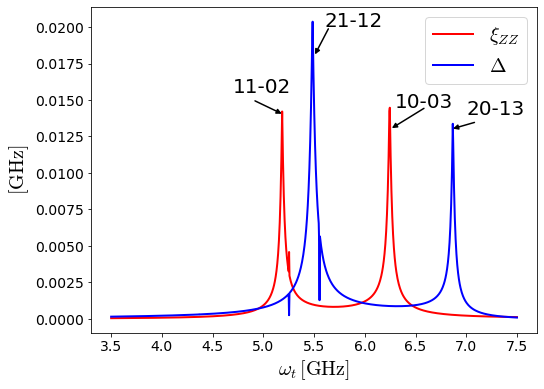

In [376]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
def plot_zz_delta(
    omega_vec: np.ndarray,
    zz_coup_vec: np.ndarray,
    delta_f_vec: np.ndarray,
    opt: dict
) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(omega_vec, np.abs(zz_coup_vec), linewidth=opt['lw'], color='red', label='$\\xi_{ZZ}$')
    ax.plot(omega_vec, np.abs(delta_f_vec), linewidth=opt['lw'], color='blue', label='$\Delta$')
    ax.axes.set_xlabel("$\omega_t \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    ax.text(7.0, 0.014, '20-13', fontsize=opt['fs'])
    ax.annotate("", xy=(6.85, 0.013), xytext=(7.1, 0.0135), \
                arrowprops=dict(arrowstyle='-|>', linewidth=1.5, fc='k'))
    ax.text(6.3, 0.0145, '10-03', fontsize=opt['fs'])
    ax.annotate("", xy=(6.25, 0.013), xytext=(6.6, 0.0145), \
                arrowprops=dict(arrowstyle='-|>', linewidth=1.5, fc='k'))
    ax.text(5.6, 0.02, '21-12', fontsize=opt['fs'])
    ax.annotate("", xy=(5.5, 0.018), xytext=(5.65, 0.02), \
                arrowprops=dict(arrowstyle='-|>', linewidth=1.5, fc='k'))
    ax.text(4.7, 0.0155, '11-02', fontsize=opt['fs'])
    ax.annotate("", xy=(5.2, 0.014), xytext=(4.9, 0.015), \
                arrowprops=dict(arrowstyle='-|>', linewidth=1.5, fc='k'))    
    plt.legend(fontsize=opt['fs'])
    plt.show()
    
plot_zz_delta(omega_vec, zz_coup_vec, delta_f_vec, plot_setup)   
    

From the plot I conclude that there is no clear point where there is a separation between the $ZZ$ coupling and the $\Delta$ parameter in the Ficheux paper like in a fluxonium-fluxonium system. The gate will have to deal with a $ZZ$ coupling, and the smartest thing seems to to work with the transmon close to the right peak of the $\Delta$ parameter. There the $ZZ$ coupling is small (about $300 \, \mathrm{kHz}$), but it is impossible to hit desired frequency out of fabrication. Thus one needs a bit of tunability of the transmon frequency and the result would be a microwave + flux-biased gate, which could be unappealling. 

However, we also notice that the right peak of $\xi_{ZZ}$ is clearly due to hybridization between the $\lvert 10 \rangle-\lvert 03 \rangle$ transition which was at about 

In [331]:
display(Latex(r'$\omega^{{f}}_{{{} \rightarrow {}}}/2 \pi$ = {:.3f} GHz'.format(0, 3, energies_f[3] - energies_f[0] )))

<IPython.core.display.Latex object>

This means that by placing the transmon above this frequency (say $6.8 \, \mathrm{GHz}$) we can perform a CPHASE-like gate by flux tuning at the interaction point of the $\lvert 10 \rangle-\lvert 03 \rangle$ transition. By correcting for single-qubit phases the gate would realize the unitary
$$
U = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
$$
which by applying the single-qubit unitary $Z \otimes I$ becomes the $\mathrm{CZ}$ gate. Also the gate speed seems comparable to the transmon-transmon case, but also the $ZZ$ coupling problem. Additionally, the gate loses the protection against relaxation of the fluxonium, but this is true for any fluxonium gate that uses the higher levels. Finally, by reducing the Josephson energy of the fluxonium $\omega_{03}^f$ can be reduced and we can accordingly take transmons with lower frequency. 

# 2. CPHASE-like gate using the $\lvert 10 \rangle-\lvert 03 \rangle$ transition

We consider a transmon that has an initial frequency of $6.8 \, \mathrm{GHz}$.

In [401]:
omega_in = 6.8
n_points = 1000
phi_vec = np.linspace(0.8, 1.0, n_points) #phi/phi_0
level_in_plot = 2
level_f_plot = 5
energy_phi_vec = np.zeros([level_f_plot - level_in_plot, n_points], dtype=float)
trans_in = pysqkit.qubits.SimpleTransmon('T', omega_in, delta_t, dim_hilbert=n_fock_t)
energies_t_in = trans_in.eig_energies()
bare_energies_in = np.zeros(levels_f*n_fock_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        bare_energies_in[count] = energies_t[k] + energies_f[m]
        count += 1
label_converter_in = np.argsort(bare_energies_in)
bare_energy_mat_in = np.zeros([levels_t, levels_f], dtype=float)
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        bare_energy_mat_in[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, np.sort(bare_energies_in), 
                                                         label_converter_in)

In [402]:
start = time.time()

for i in range(0, n_points):
    omega_phi = omega_in*np.sqrt(np.abs(np.cos(np.pi*phi_vec[i])))
    trans_phi = pysqkit.qubits.SimpleTransmon('T', omega_phi, delta_t, dim_hilbert=n_fock_t)
    energies_phi, eig_states_phi = trans_phi.eig_states(levels_t)
    flx_trans_phi = trans_phi.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    energies_phi = flx_trans_phi.eig_energies()
    energy_phi_vec[:, i] = energies_phi[level_in_plot: level_f_plot]
    

end=time.time()

print("Computation time: " + str(end - start) + ' s')

Computation time: 8.105153799057007 s


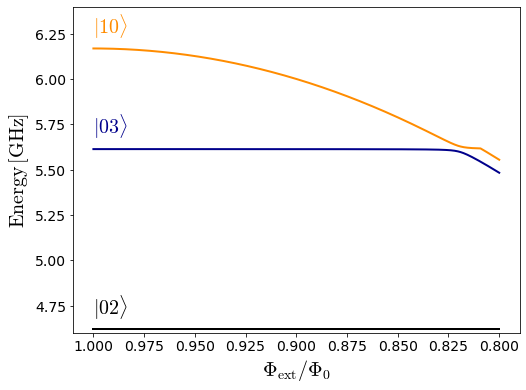

In [422]:
def plot_levels_phi(
    phi_vec: np.ndarray,
    energy_phi_vec: np.ndarray,
    opt: dict
) -> None:
    color_plot = ['black', 'darkblue', 'darkorange']
    fig, ax = plt.subplots(figsize=(8, 6))
    levels = energy_phi_vec.shape[0]
    for lev in range(0, levels):
        ax.plot(phi_vec, energy_phi_vec[lev, :], color=color_plot[lev], linewidth=opt['lw'])
    ax.axes.set_xlabel('$\Phi_{\mathrm{ext}}/\Phi_0$', fontsize=opt['fs'])
    ax.axes.set_ylabel('$\mathrm{Energy} \, [\mathrm{GHz}]$', fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    ax.text(1, 4.7, '$\\vert 02 \\rangle$', fontsize=opt['fs'], color=color_plot[0])
    ax.text(1, 5.7, '$\\vert 03 \\rangle$', fontsize=opt['fs'], color=color_plot[1])
    ax.text(1, 6.25, '$\\vert 10 \\rangle$', fontsize=opt['fs'], color=color_plot[2])
    ax.set_ylim(4.6, 6.4)
    plt.gca().invert_xaxis()
    plt.show()

plot_levels_phi(phi_vec, energy_phi_vec, plot_setup)

In [390]:
energy_phi_vec.shape[0]

6